In [1]:
!qbraid jobs enable amazon_braket

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

from braket.aws import AwsDevice
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive 

from iquhack_utils import find_UDG_radius, visualize_graph, get_blockade_radius, C6, save_result_json, open_json

from utils import postprocess_MIS, analysis_MIS

In [2]:
plt.rcParams['figure.dpi'] = 140

In [3]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [4]:
def square_lattice(num_rows, num_cols):
    points = []
    
    num_centers = num_rows * num_cols
    num_corners = (num_rows + 1) * (num_cols + 1)
    graph_connections = []
    
    # Build corners
    for row in range(num_rows + 1):
        for col in range(num_cols + 1):
            start = np.array([col, row])
            points.append(start)
            
    # Build centers
    curr_id = num_corners
    for row in range(num_rows):
        for col in range(num_cols):
            start = np.array([col, row])
            points.append(start + np.array([1/2, 1/2])) # centers
            bottomleft_corner_id = row * (num_cols + 1) + col
            bottomright_corner_id = bottomleft_corner_id + 1
            topleft_corner_id = bottomleft_corner_id + num_cols + 1
            topright_corner_id = topleft_corner_id + 1
            graph_connections.append((topleft_corner_id, curr_id))
            graph_connections.append((topright_corner_id, curr_id))
            graph_connections.append((bottomleft_corner_id, curr_id))
            graph_connections.append((bottomright_corner_id, curr_id))
            curr_id = curr_id + 1
            # points.append(start + np.array([0, 1]))
    # points.append(np.array([num_cells, 0]))
    # points.append(np.array([num_cells, 1]))
    
    centers = range(num_centers)
    corners = range(num_centers, num_centers + num_corners)
    
    graph = nx.Graph(graph_connections)
    
    return np.array(points), graph

In [5]:
def linear_chain(n_verts, direction):
    points = []
    for i in range(n_verts):
        if direction == 'HORIZ':
            points.append(np.array([i, 0]))
        if direction == 'VERT':
            points.append(np.array([0, i]))
        if direction == 'DIAG':
            points.append(np.array([i, i]) / np.sqrt(2)) 
            
    graph = nx.Graph([(i, i+1) for i in range(n_verts - 1)])
    return np.array(points), graph

Points: [[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
# Points: 8


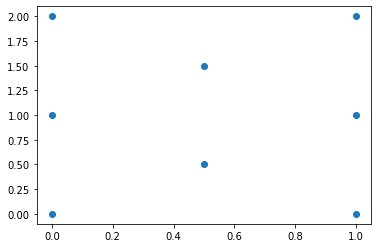

Edges: [(2, 6), (2, 7), (6, 3), (6, 0), (6, 1), (3, 7), (4, 7), (7, 5)]


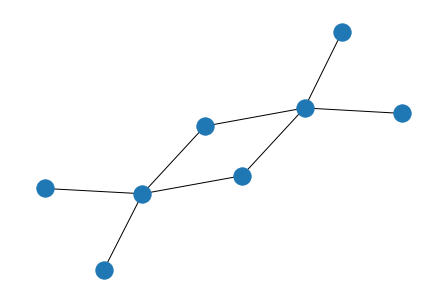

In [6]:
# points, graph = linear_chain(18, 'DIAG')
points, graph = square_lattice(2, 1)

print(f"Points: {points}")
print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

print(f"Edges: {graph.edges}")
nx.draw(graph)

Unit Disk Radius: 0.8408964152537146
Minimum Radius: 0.7071067811865476
Maximum Radius: 1.0
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]


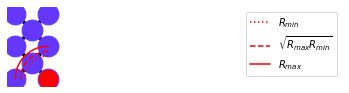

In [7]:
unitdisk_radius, min_radius, max_radius = find_UDG_radius(points, graph)
print(f"Unit Disk Radius: {unitdisk_radius}\nMinimum Radius: {min_radius}\nMaximum Radius: {max_radius}")

figure = plt.figure()
axes = plt.subplot(1,1,1)
visualize_graph(axes, graph, points)

x0, y0 = (1,0)
angles = np.linspace(np.pi/2,np.pi,1001)

axes.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
axes.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
axes.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

axes.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
axes.set_xlim((-0.25,10))

plt.legend(loc="upper right",)
plt.show()

Blockade Radius: 8.044e-06m
Unit Disk Radius: 0.841


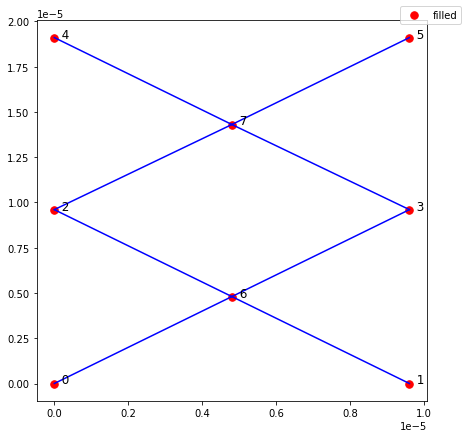

In [8]:
detuning_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(detuning_final, 0) # no rabi amplitude at the end
print('Blockade Radius: {:0.3e}m'.format(blockade_radius))
print('Unit Disk Radius: {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius

# Generate the atom register
register = AtomArrangement()
for x in points:
    register.add((a * x).round(7))

# print(register)
show_register(register, blockade_radius = blockade_radius)

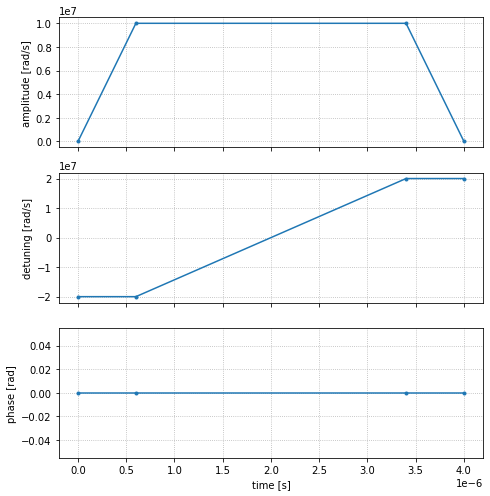

In [9]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
detuning_initial = -20e6     # rad / sec
detuning_final = detuning_final # Defined above

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_initial, detuning_initial, detuning_final, detuning_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [10]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [11]:
device = LocalSimulator("braket_ahs")
ahs_run = device.run(ahs_program, shots=1000)

result  = ahs_run.result()
save_result_json("2x1_square_lattice_mis.json", result)

[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]


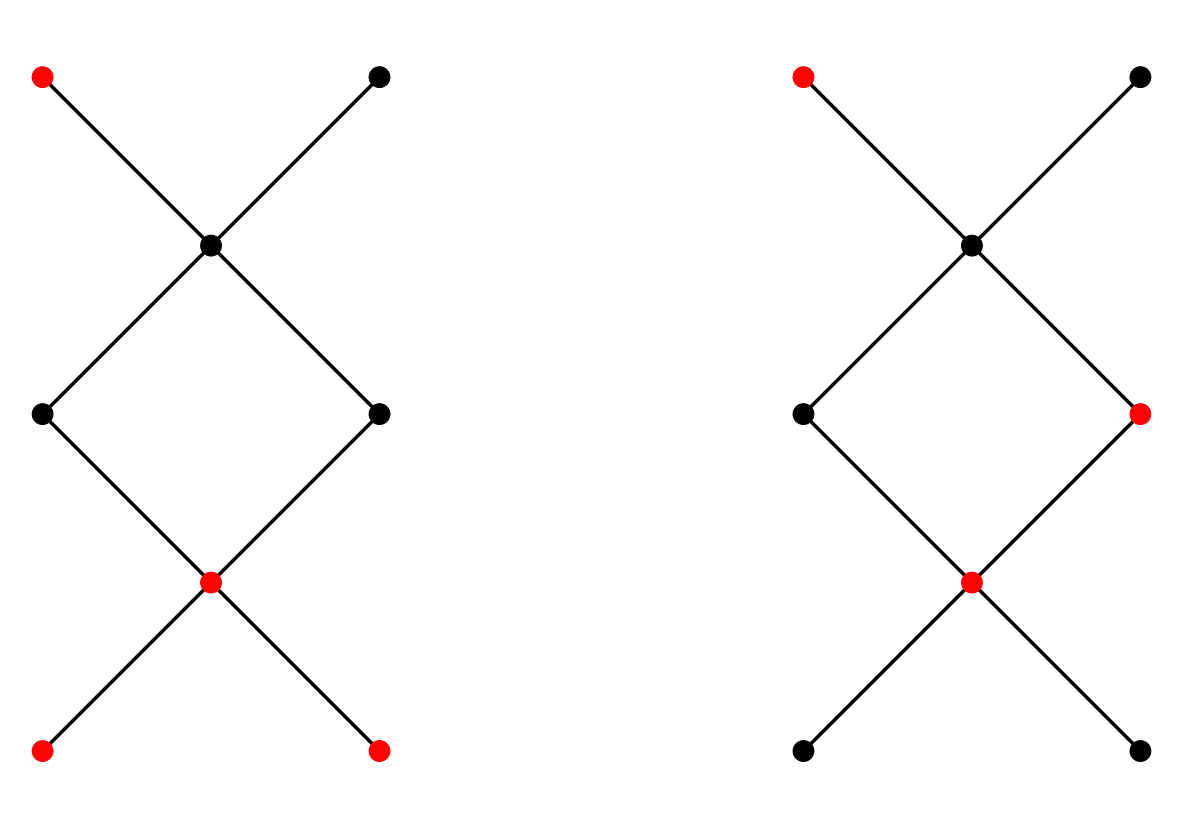

In [12]:
filename = "2x1_square_lattice_mis.json"
result_json = open_json(filename)
num_measurements = len(result_json["measurements"])    
sequences = [result_json["measurements"][i]["post_sequence"] for i in range(num_measurements)]

figure = plt.figure(figsize=(25,15))

start = 0
num_shown = 2
for i in range(num_shown):
    axes = plt.subplot(1,num_shown,i+1)
    
    color_lookup = {0:"r",1:'k'}
    sequence_colors = [color_lookup[sequences[i+start][j]] for j in range(len(sequences[i]))]
    visualize_graph(axes, graph, points, node_colors = sequence_colors)
    
plt.show()

In [18]:
sequences

[[1, 0, 1, 0, 0, 0, 1, 1],
 [1, 0, 0, 1, 1, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 1, 0, 0, 1, 1],
 [1, 0, 0, 0, 1, 0, 1, 1],
 [1, 0, 0, 0, 1, 0, 1, 1],
 [1, 0, 0, 0, 1, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [1, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 1, 1, 0, 0, 1, 1],
 [0, 1, 1, 1, 0, 0, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 0, 0, 1, 1],
 

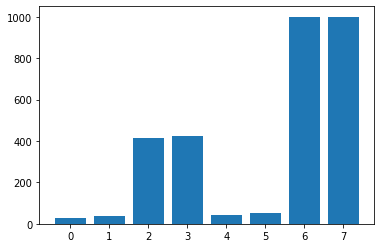

In [13]:
# result_json["measurements"][5]
post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
post_bitstrings.shape
n_occur_ground = np.sum(post_bitstrings, axis=0)
n_occur_ground.shape
# unique_n_occur, count = np.unique(n_occur_ground, return_counts = True)

# unique_n_occur
plt.bar(list(range(0, n_occur_ground.size)), n_occur_ground)
plt.show()

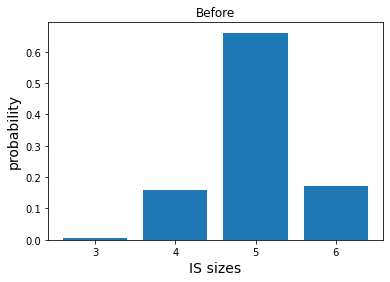

In [14]:
post_bitstrings = np.array([q["post_sequence"] for q in result_json["measurements"]])
IS_sizes = np.sum(1-post_bitstrings,axis=1)
unique_IS_sizes, counts = np.unique(IS_sizes, return_counts=True)

plt.bar(unique_IS_sizes, counts/counts.sum())
plt.title("Before")
plt.xticks(unique_IS_sizes)
plt.xlabel("IS sizes",fontsize=14)
plt.ylabel("probability",fontsize=14)
plt.show()

Average pre-processed size:  5.0010
Average post-processed IS size: 5.0010
FIXED


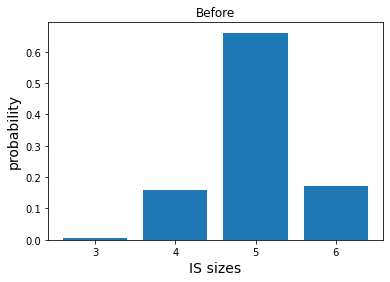

None

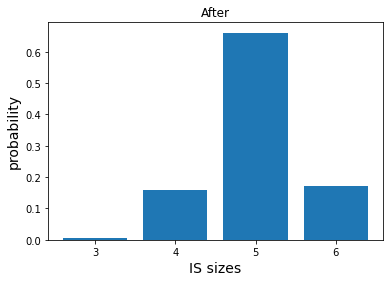

None

[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]
[[0.  0. ]
 [1.  0. ]
 [0.  1. ]
 [1.  1. ]
 [0.  2. ]
 [1.  2. ]
 [0.5 0.5]
 [0.5 1.5]]


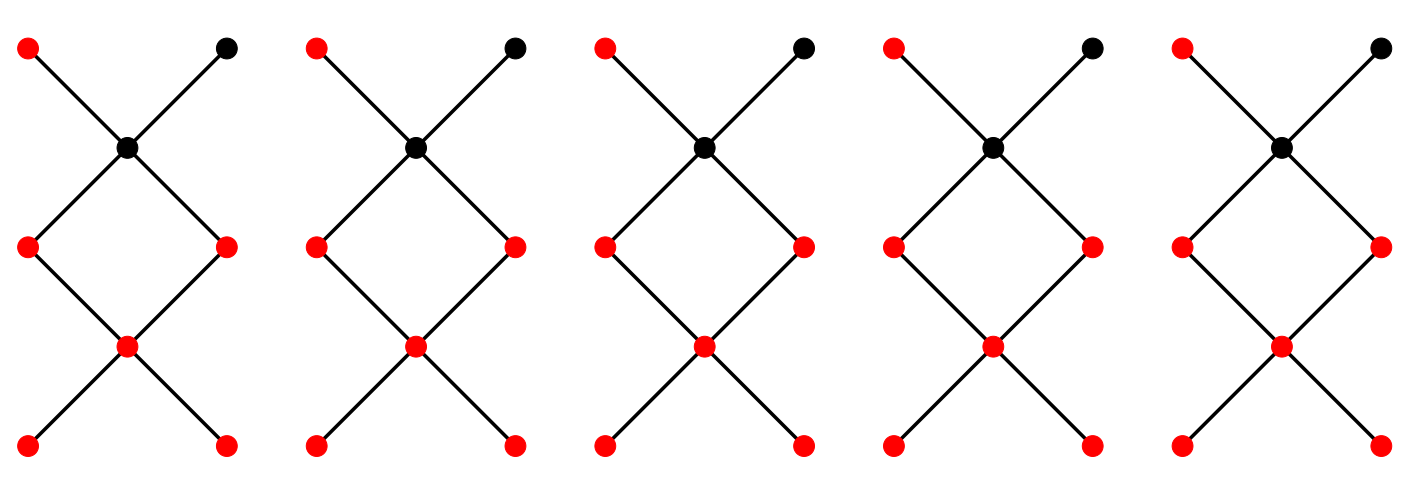

In [17]:
result_json = open_json(filename)
IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
# ind = list(range(1,n_show+1))
n_show = min(len(ind),5)

figure = plt.figure(figsize=(25,15))
for i in range(n_show):
    axes = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(axes, graph, points, node_colors = seqs_color)
    
plt.show()